In [64]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np


acc = pd.read_parquet("/Users/Ahnaf/Downloads/dataset_47052.pq")
mem = pd.read_parquet("/Users/Ahnaf/Downloads/dataset_44225.pq")

In [65]:
print(acc.head())

   Shift Equipment Weather Operator_Experience  Production_Tons  \
0    Day     Truck    Rain              Novice              147   
1  Night     Drill     Fog        Intermediate               97   
2    Day     Drill   Clear        Intermediate              141   
3    Day   Crusher   Clear              Novice              116   
4    Day     Truck   Clear              Novice              104   

   Maintenance_Hours Accident  
0                  2        0  
1                  9        0  
2                  2        0  
3                  2        1  
4                  5        0  


In [66]:
print(mem.head())

  MEMBERSHIP_NUMBER  MEMBERSHIP_TERM_YEARS  ANNUAL_FEES MEMBER_MARITAL_STATUS  \
0            A00001                     29     113125.0                     M   
1            A00002                     38     112220.0                     M   
2            A00003                     12     100000.0                     M   
3            A00004                     12     100000.0                     M   
4            A00005                     46     100000.0                     M   

  MEMBER_GENDER  MEMBER_ANNUAL_INCOME  MEMBER_OCCUPATION_CD  \
0             M            25200000.0                   1.0   
1             M            10339200.0                   1.0   
2             M            14400000.0                   1.0   
3             M             9000000.0                   1.0   
4             M             4800000.0                   1.0   

  MEMBERSHIP_PACKAGE  MEMBER_AGE_AT_ISSUE  ADDITIONAL_MEMBERS PAYMENT_MODE  \
0             TYPE-B                   45               

# Accident

In [67]:
plt.style.use("ggplot")
plt.rcParams["axes.facecolor"] = "white"      # Achsen-Hintergrund
#plt.rcParams["figure.facecolor"] = "white"    # Gesamt-Hintergrund
plt.rcParams["grid.color"] = "lightgray"

In [68]:
acc['Accident'] = acc['Accident'].astype(int)
acc["Accident_Text"] = (
    acc["Accident"].map({1: "Accident", 0: "No Accident"}).fillna("Not specified")
)

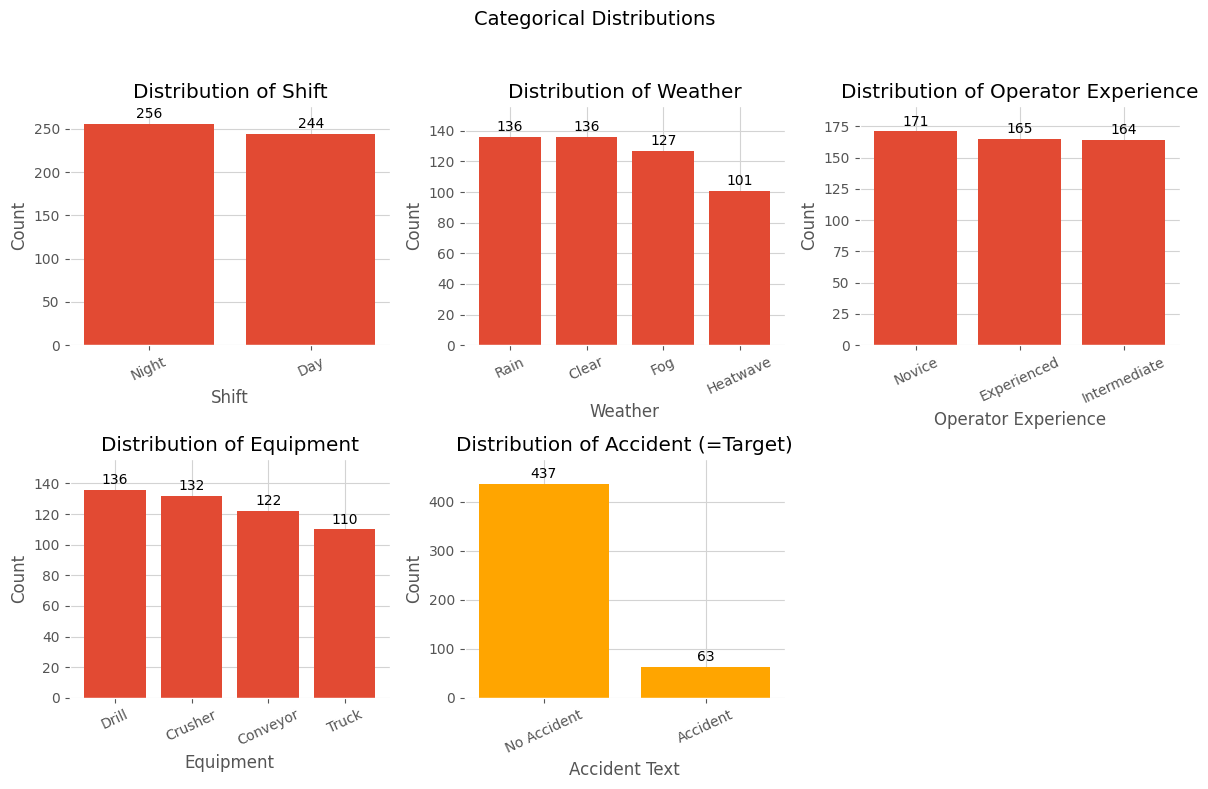

In [69]:
import math
import matplotlib.pyplot as plt

cols = ["Shift", "Weather", "Operator_Experience", "Equipment", "Accident_Text"]
present = [c for c in cols if c in acc.columns]

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharey=False, squeeze=False)
axes = axes.ravel()

for ax, col in zip(axes, present):
    s = acc[col].astype("string").fillna("Not specified")
    counts = s.value_counts()

    is_acc_text = (col == "Accident_Text")
    bar_color = "orange" if is_acc_text else None
    extra_margin = 50 if is_acc_text else 20

    ax.bar(counts.index.astype(str), counts.values, color=bar_color)

    title_text = "Distribution of Accident (=Target)" if is_acc_text else f"Distribution of {col.replace('_', ' ')}"
    ax.set_title(title_text)

    ax.set_xlabel(col.replace("_", " "))
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", labelrotation=25)
    ax.set_ylim(0, int(counts.max()) + extra_margin)

    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{int(h)}", (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom", xytext=(0, 2), textcoords="offset points")

for ax in axes[len(present):]:
    ax.set_visible(False)

fig.suptitle("Categorical Distributions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Membership

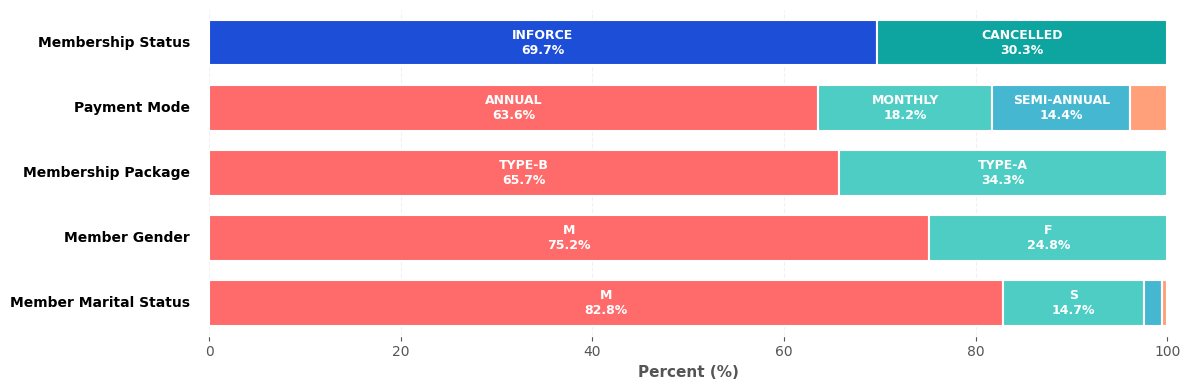

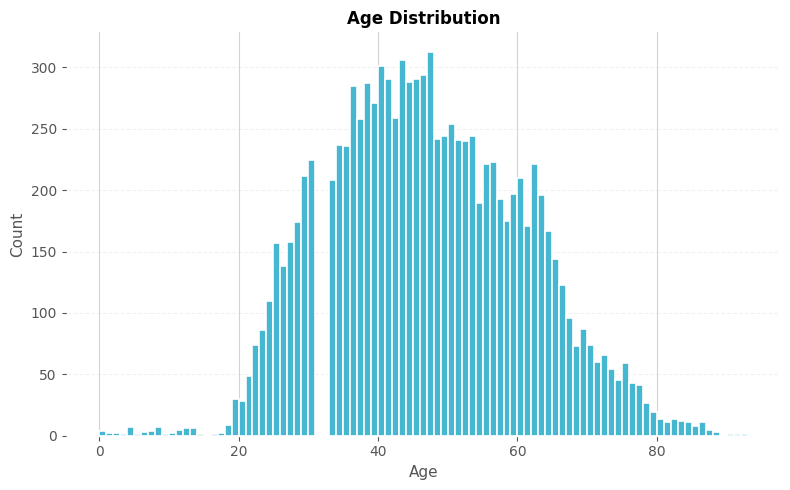

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_100(df, top_n=8):
    exclude = {"START_DATE", "END_DATE"}
    exclude_like = ["agent", "membership_number", "membership_no"]
    pats = tuple((p.lower() for p in exclude_like))
    
    cat_cols = [
        c for c in df.select_dtypes(include=['object', 'category', 'bool']).columns
        if c not in exclude and not any(p in c.lower() for p in pats)
    ]
    
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8',
                   '#F7DC6F', '#BB8FCE', '#85C1E2', '#F8B400', '#52B788']
    special_colors = ['#1D4ED8', '#0EA5A0']
    
    fig, ax = plt.subplots(figsize=(12, 0.6*len(cat_cols) + 1))
    y_pos = np.arange(len(cat_cols))
    
    for idx, col in enumerate(cat_cols):
        s = df[col]
        counts = s.value_counts()
        
        if len(counts) > top_n:
            top = counts.nlargest(top_n).index
            counts = s.where(s.isin(top), 'Other').value_counts()
        
        percentages = (counts / counts.sum() * 100).sort_values(ascending=False)
        
        # Letzter Balken benutzt special_colors
        palette = special_colors if idx == len(cat_cols) - 1 else base_colors
        
        left = 0.0
        for color, (cat, pct) in zip(palette, percentages.items()):
            ax.barh(y_pos[idx], pct, left=left, height=0.7,
                    color=color, edgecolor='white', linewidth=1.5)
            
            if pct > 5:
                ax.text(left + pct/2, y_pos[idx], f'{cat}\n{pct:.1f}%',
                        ha='center', va='center', fontsize=9,
                        fontweight='bold', color='white')
            
            left += pct
        
        ax.text(-2, y_pos[idx], col.replace("_", " ").title(),
                ha='right', va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlim(0, 100)
    ax.set_ylim(-0.5, len(cat_cols)-0.5)
    ax.set_xlabel('Percent (%)', fontsize=11, fontweight='bold')
    ax.set_yticks([])
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    for spine in ('top', 'right', 'left'):
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_age_distribution(df, age_col="MEMBER_AGE_AT_ISSUE"):
    x = pd.to_numeric(df[age_col], errors="coerce").dropna()
    fig, ax = plt.subplots(figsize=(8, 5))
    amin, amax = int(x.min()), int(x.max())
    
    ax.hist(x, bins=np.arange(amin, amax + 2),
            color='#45B7D1', edgecolor='white', linewidth=1.2)
    
    ax.set_title('Age Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Age', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_stacked_100(mem, top_n=8)
plot_age_distribution(mem, age_col="MEMBER_AGE_AT_ISSUE")